In [63]:
from PIL import Image
import cv2
import random

import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

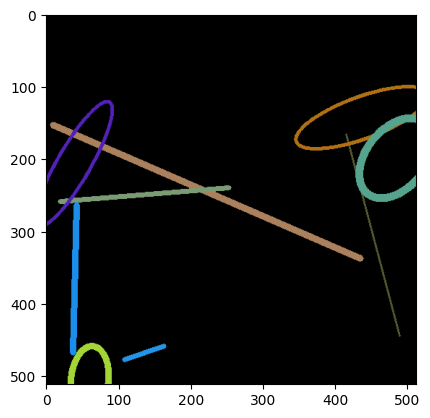

In [64]:
def generate_image_with_shapes(image_width, image_height, n_lines, m_ovals):
    image = np.zeros((image_height, image_width, 3), dtype=np.uint8) * 255

    for _ in range(n_lines):
        start_point = (random.randint(0, image_width), random.randint(0, image_height))
        end_point = (random.randint(0, image_width), random.randint(0, image_height))
        color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
        thickness = random.randint(2, 10)
        cv2.line(image, start_point, end_point, color, thickness)

    for _ in range(m_ovals):
        center = (random.randint(0, image_width), random.randint(0, image_height))
        axes = (random.randint(20, 100), random.randint(20, 100))
        angle = random.randint(0, 360)
        startAngle = 0
        endAngle = 360
        color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
        thickness = random.randint(2, 10)
        cv2.ellipse(image, center, axes, angle, startAngle, endAngle, color, thickness)

    return image

# Parameters
n_lines = 5
m_ovals = 4

# Generate image
image = generate_image_with_shapes(512, 512, n_lines, m_ovals)

cv2.imwrite("test_random.png", cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
plt.imshow(image)

In [65]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [66]:
width = height = 128
device = "cuda"

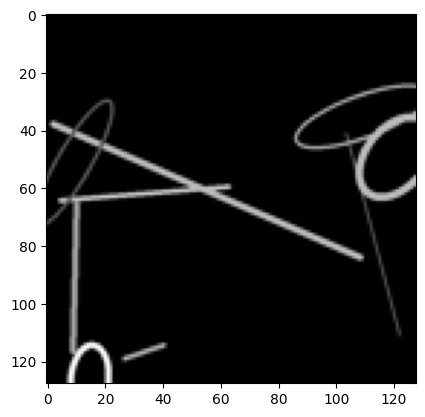

In [67]:
target_image = Image.open("test_random.png")

target_image = target_image.convert("L").resize((height, width))
plt.imshow(target_image, cmap="grey")
plt.show()

target_image = transforms.ToTensor()(target_image).to(device).squeeze(0)

In [73]:
from gaussian_model import Gaussian2DImage, combined_loss
from IPython.display import clear_output

num_gaussians = 300

num_steps = 7000
dump_every = 100
reset_every = 3000
densify_from = 500
densify_until = 15000
densify_every = 100

In [78]:
def optimization_loop(gaussian_image):

    gaussian_image.create_optimizer()
    
    for step in range(num_steps):
    
        gaussian_image.optimizer.zero_grad()

        reconstructed_image = gaussian_image()

        loss = combined_loss(reconstructed_image, target_image, lambda_param=0.2)
        loss.backward()
    
        if loss < 1e-5:
            print(f"Small loss at iter {step}")
            break
    
        if loss.isnan():
            print(f"NaNs at iter {step}")
            break
    
        gaussian_image.optimizer.step()
        gaussian_image.update_learning_rate(step)
        
        if step % dump_every == 0:
            clear_output(wait=True)
            
            result = torch.cat([
                reconstructed_image.unsqueeze(0), 
                target_image.unsqueeze(0), 
                torch.sqrt((reconstructed_image - target_image) ** 2).unsqueeze(0)
            ], dim=2)
            result = transforms.ToPILImage()(result)
            
            plt.figure(figsize=(10, 5))
            plt.imshow(result, cmap="grey")
            plt.title(f"step: {step}")
            plt.show()
    
        if step < densify_until:
            # clone and split gaussians
            if step > densify_from and step % densify_every == 0:
                gaussian_image.densify_and_prune(scale_threshold=3)
        
            # reset opacities
            if step > 0 and step % reset_every == 0:
                gaussian_image.reset_opacity()

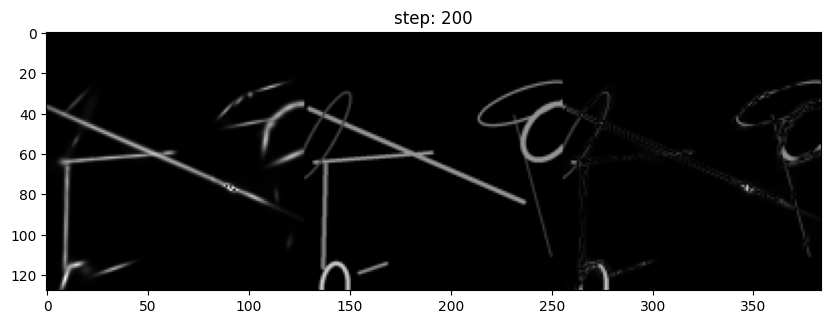

In [ ]:
gaussian_image = Gaussian2DImage(num_gaussians, width, height).to(device)
optimization_loop(gaussian_image)